In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.constants import golden

%matplotlib inline

In [47]:
class DataCls:
    def __init__(self):
        self.ignore = ['II', 'I', 'and', 'Team', 'Center', 'Program', 'Shift', 'Associate', 'Senior', 'CA', 'MD', 'NY', 'GA', 'CO', 'AZ', 'IL', 'LA', 'MA', 'MI', 'FL', 'MN', 'NC', 'NJ', 'NV', 'OR', 'PA', 'SC', 'TN', 'TX', 'City', 'VA', '1', 'Pick', 'WI', 'Lake', 'Chicago', 'Las', 'Vegas', 'Save', 'Time', 'VT', 'S', 's', 'New', '–']
        self._get_regions()
        self._get_pop()
        self.jobs_states_dates = False
        self.most_common=False
        self.keywords_states_dates = {state: pd.DataFrame() for state in self.regions_dict.values()}
        
    def _get_regions(self):
        self.regions = pd.read_csv('us_states.csv', usecols=[1,2], names=['state', 'abrv'])
        self.regions.set_index('state', inplace=True)
        self.regions_dict = self.regions.to_dict()['abrv']
    
    def _get_pop(self):
        temp = pd.read_csv('nst-est2018-alldata.csv')
        temp['NAME'].replace(self.regions_dict, inplace=True)
        temp = temp[['NAME','POPESTIMATE2018']].rename({'POPESTIMATE2018': 'population', 'NAME': 'region'}, axis=1)
        self.usa_pop = temp[temp['region'].isin(self.regions['abrv'])].set_index('region')
        
    def get_data(self, paths=['temp_datalab_records_job_listings.csv', 'temp_datalab_records_job_listings 2.csv'], chunksize=10**7, test=False, word_column='title', date_column='date_added'):
        for j, path in enumerate(paths):
            for i, chunk in enumerate(pd.read_csv(path, chunksize=chunksize)):
                chunk.drop(['dataset_id', 'listing_id', 'domain', 'url','location_string', 'category', 'number_of_openings', 'location_string', 'entity_id', 'city_lat', 'city_lng', 'cusip', 'isin'], axis=1, inplace=True)
                for key in ['as_of_date', 'date_updated', 'date_added', 'posted_date']:
                    chunk[key] = chunk[key].str[:10].apply(self.convert_date)
                chunk['region'].replace(self.regions_dict, inplace=True)
                chunk = chunk[chunk['region'].isin(self.regions_dict.values())]
                self.usa = chunk

                self._get_jobs_states_dates(word_column)
                self._get_keywords_states_dates(date_column)
                print('File %i, Chunk %i' %(j, i))
                if test is not False:
                    if i >= test:
                        break
                else:
                    pass
        
    def load_subset(self):
        if 'subset.csv' in os.listdir():
            temp = pd.read_csv('subset.csv', index_col=0)
            for key in ['as_of_date', 'date_updated', 'date_added', 'posted_date']:
                temp[key] = temp[key].str[:10].apply(self.convert_date)
            self.usa = temp
        else:
            print('subset.csv does not exist')
            
    def load_processed_df(self, jobs='jobs_states_dates.csv', keywords='keyword_states_dates.csv'):
        jobs = pd.read_csv(jobs, index_col=0)
        keywords = pd.read_csv(keywords, index_col=0)
        for key in ['as_of_date', 'date_updated', 'date_added', 'posted_date']:
            try:
                jobs[key] = temp[key].str[:10].apply(self.convert_date)
                
            except:
                pass
        self.jobs_states_dates = jobs
        self.keywords_states_dates = keywords
        
    def _get_jobs_states_dates(self, word_column='title'):
        temp = self.usa.groupby(['region', 'date_added']).count()[word_column]
        if self.jobs_states_dates is False:
            self.jobs_states_dates = pd.Series()
            self.jobs_states_dates = self.jobs_states_dates.add(temp, level='region', fill_value=0)
        else:
            self.jobs_states_dates = self.jobs_states_dates.add(temp, fill_value=0)
        
    def _get_keywords_states_dates(self, date_column='date_added'):
        if self.most_common is False:
            temp = self.count_words(self.usa, 'region', ignore=self.ignore)
            temp = temp.T.sum().nlargest(200)
            self.most_common = temp
        else:
            pass
        for state, group in self.usa.groupby('region'):
            self.keywords_states_dates[state] = self.keywords_states_dates[state].add(self.count_words(group, date_column, ignore=self.ignore).reindex(self.most_common.index).T, fill_value=0)
    
    @staticmethod
    def count_words(df, groupby, ignore=False, word_column='title'):
        words = {}
        for key, group in df.groupby(groupby):
            temp = group[word_column].str.replace(',', ' ').str.replace('-', ' ').str.replace('/', ' ').str.replace('&', ' ').str.replace('!', ' ').str.replace('(', ' ').str.replace(')', ' ').str.replace('.', ' ').str.replace('\"', ' ').str.replace('\'', ' ').str.replace('Sr', 'Senior').str.replace('RN', 'Nurse')
            vals = temp.str.split(expand=True).stack().value_counts()
            words[key] = vals
        output = pd.DataFrame(words)
        if ignore is not False:
            output.drop(ignore, errors='ignore', inplace=True)
        else:
            pass

        return output
    
    @staticmethod
    def convert_date(s):
        try:
            output = pd.datetime.strptime(s, '%Y-%m-%d')
        except:
            output = np.nan
        return output

# Analysis of Job Postings from NYSE and Nasdaq stocks

Understanding the demand for jobs by location can give a glimpse into the economic health and trajectory of a region and aid a company in determining which areas to expand into. I would like to identify regional patterns in the talent they are looking to hire and the rates as well as the volatility of the posts.

The data is obtained from The Data Incubator, provided by Thinknum, where out of 7 parts, the analysis is performed on the first 2 for a total of 50 gb of data. I only consider job postings for the US where there is regional labels.

In [48]:
data = DataCls()
data.get_data(chunksize=10**7, test=False)

File 0, Chunk 0
File 0, Chunk 1
File 0, Chunk 2


/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2907: DtypeWarning: Columns (6,16) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


File 0, Chunk 3
File 0, Chunk 4
File 0, Chunk 5
File 0, Chunk 6
File 1, Chunk 0
File 1, Chunk 1
File 1, Chunk 2
File 1, Chunk 3
File 1, Chunk 4
File 1, Chunk 5
File 1, Chunk 6


Save the resulting dataframes as csv's so we only need to run this once.

In [49]:
data.jobs_states_dates.to_csv('jobs_states_dates.csv')
keywords_states_dates = pd.concat([group for group in data.keywords_states_dates.values()], keys=[key for key in data.keywords_states_dates.keys()])
keywords_states_dates.index.set_names(['region', 'date'], inplace=True)
keywords_states_dates.to_csv('keyword_states_dates.csv')

## Results

To start, let's look at the jobs in the US as a whole. Which state sees the most job posts?

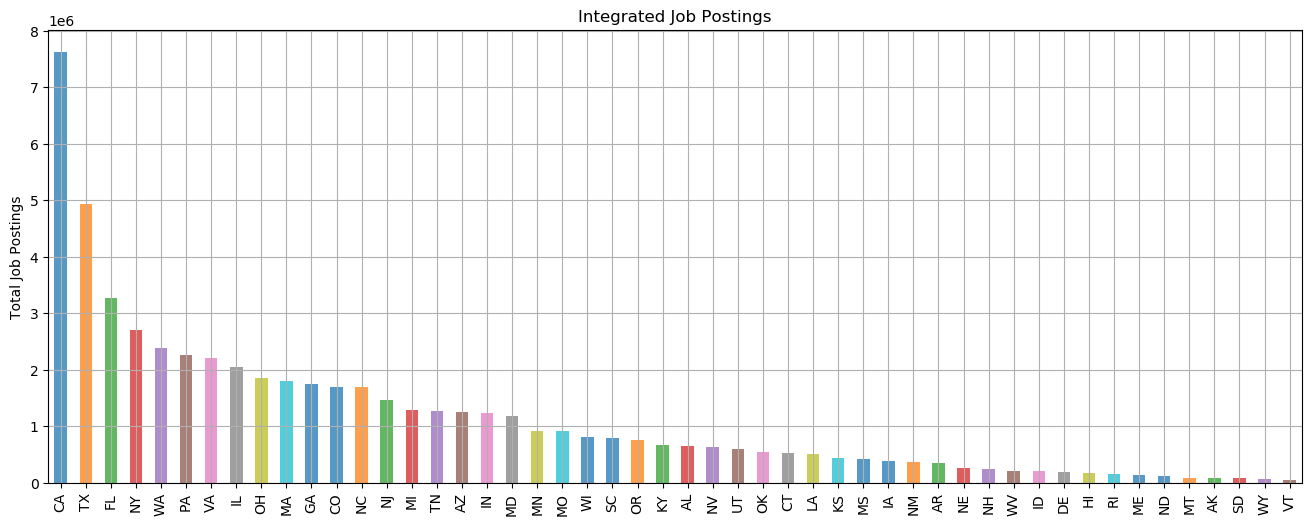

In [57]:
temp = data.jobs_states_dates.sum(level='region').sort_values(ascending=False)
order = temp.index

fig, ax = plt.subplots(figsize=(10*golden, 6), dpi=100)
temp.plot.bar(ax=ax, alpha=0.75)
ax.set_ylabel('Total Job Postings')
ax.set_xlabel('')
ax.set_xticks(range(50))
ax.set_xticklabels(list(temp.index))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_title('Integrated Job Postings')
ax.grid()

California and Texas lead the pack in number of job posts, but that is not too surprising, let's look at the posts per capita.

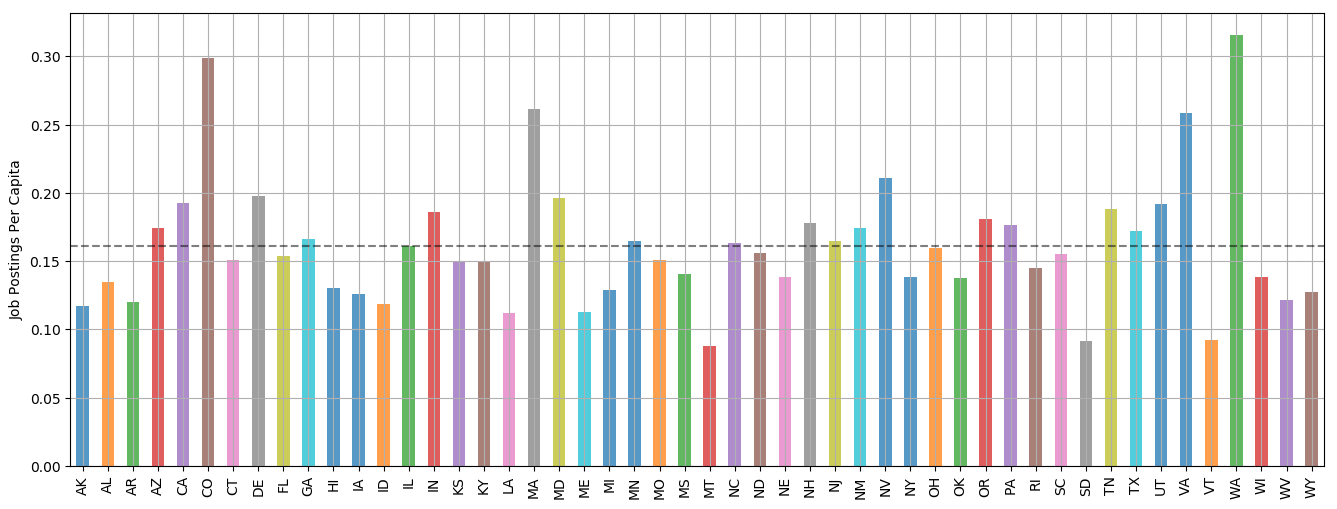

In [58]:
temp = data.jobs_states_dates.sum(level='region').sort_values(ascending=False).div(data.usa_pop['population'])

fig, ax = plt.subplots(figsize=(10*golden, 6), dpi=100)
temp.plot.bar(ax=ax, alpha=0.75)
ax.set_ylabel('Job Postings Per Capita')
ax.axhline(temp.mean(), linestyle='--', color='k', alpha=0.5)
ax.set_xlabel('')
ax.set_xticks(range(50))
ax.set_xticklabels(list(temp.index))
# ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# ax.set_title('Integrated Job Postings')
ax.grid()

Interestingly, we see CO, MA, VA, and WA coming out a whole 5% above every other state in posts per capita.

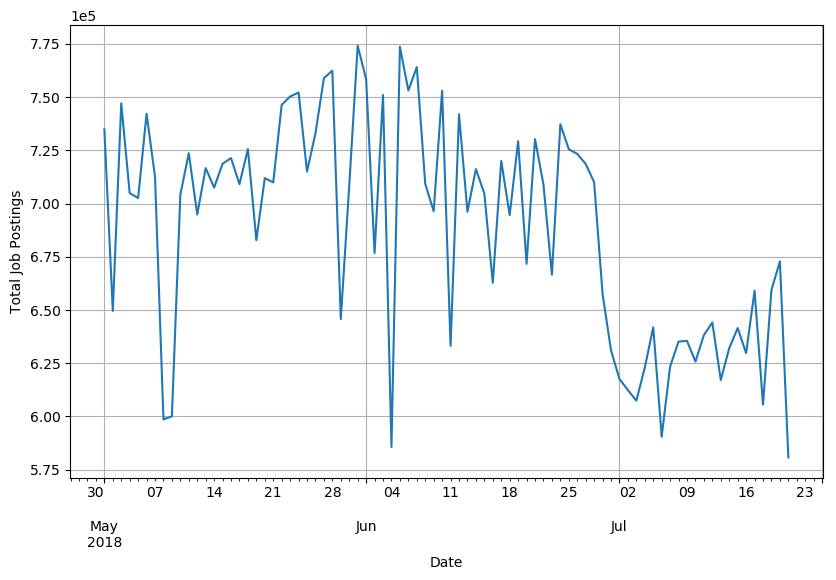

In [157]:
# states = ['CO', 'MA', 'VA', 'WA']
# temp = data.jobs_states_dates
# fig, ax = plt.subplots(figsize=(6*golden, 6), dpi=100)
# temp.loc[states].unstack().T.plot.line(ax=ax)
# ax.set_ylabel('State Job Postings')
# ax.set_xlabel('Date')
# ax.grid()

temp = data.jobs_states_dates.sum(level='date_added')

fig, ax = plt.subplots(figsize=(6*golden, 6), dpi=100)
temp.plot(ax=ax)
ax.set_ylabel('Total Job Postings')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_xlabel('Date')
ax.grid()

We can see the 6 most popular words used in job titles for each state and the proportion of all jobs they occupy. There are gaps in the analysis, as the word finding does not separate from each title instance, so some words may be counted multiple times, but is still an accurate reading of the attributes wanted.

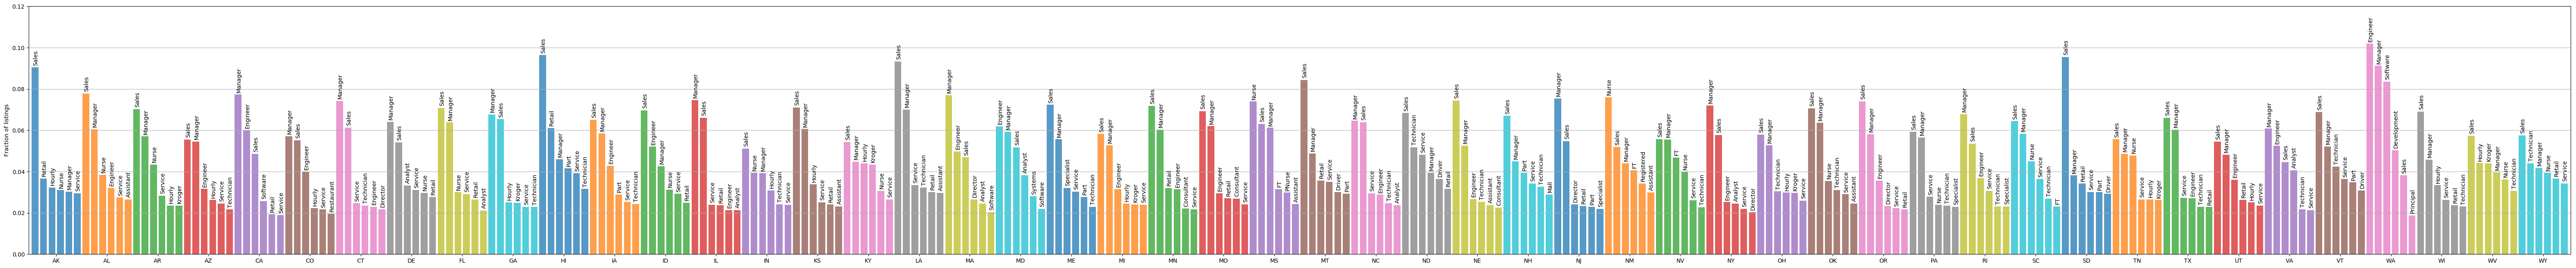

In [85]:
temp_norm = keywords_states_dates.sum(level='region').sum(axis=1)
temp = keywords_states_dates.sum(level='region').sort_index().T.div(temp_norm)

l=6
domain = np.array(range(l))
fig, ax = plt.subplots(figsize=(80, 8), dpi=100)
d = {}
for i, group in enumerate(temp.iteritems()):
    state = group[0]
    vals = group[1].nlargest(l)
    x = domain + l*i
    jobs = vals.index
    d[state] = jobs
    ax.bar(x, vals, alpha=0.75)
    for j, job in enumerate(jobs):
        if vals[j] == 0:
            job = 'N/A'
        ax.text(x[j]-0.25, vals[j]+0.001, job, rotation=90, verticalalignment='bottom')
ax.set_xlim(-0.75, 50 * l - 0.25)
ax.set_xticks([])
ax.yaxis.grid()
ax.set_ylim(0, 0.12)
ax.set_xticks(np.linspace((l-1)/2, 50*l-0.5*(l+1), 50))
ax.set_xticklabels(temp.columns)
ax.set_ylabel('Fraction of listings')

state_common = pd.DataFrame(d)

Considering the states with the largest number of posts per capita (CO, MA, VA, WA) we see that they have a higher fraction of posts being tech related. The keywords, engineer, manager, software are overrepresented compared to sales.

Interestingly, despite the fact that I only use the global top 200 keywords, Kroger contributes a large number of roles in multiple state including AR, GA, IN, KY, MI,  and WV.

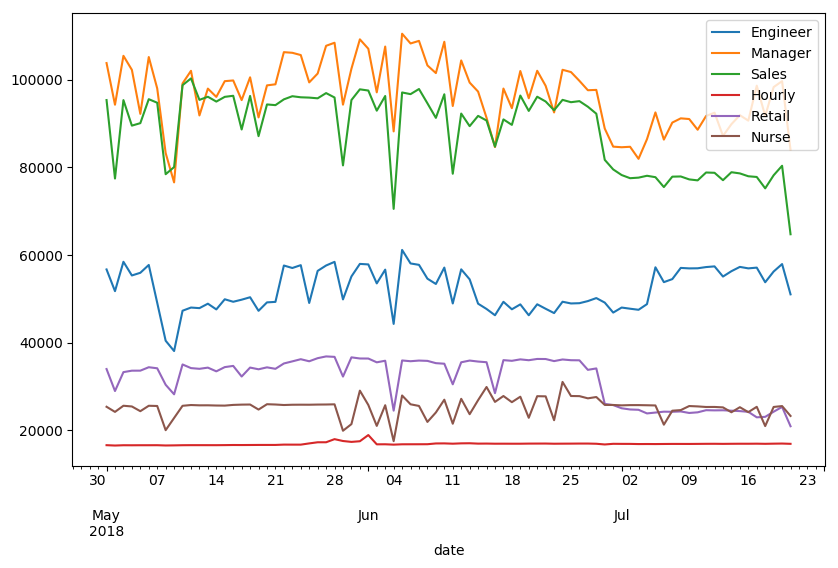

In [168]:
fig, ax = plt.subplots(figsize=(6*golden, 6), dpi=100)
keywords_states_dates.sum(level='date')[['Engineer', 'Manager', 'Sales', 'Hourly', 'Retail', 'Nurse']].plot(ax=ax)

This made me wonder, is this influx of engineering jobs due to new job creation, or is it just due to reshuffling of jobs from one state to another, e.g. is the rent in SF too damn high, making people want to move to CO, MA, WA, VA?

In short, no, there are no strong negative correlations over time when comparing these high per capita states and the states with each other, or with the states with the most posts (CA, TX, NY, FL).

In [131]:
temp = keywords_states_dates['Engineer'].reset_index()
temp_corr = temp.pivot(index='date', columns='region', values='Engineer').corr()
temp_corr[states].loc[states+list(order[:4])]

region,CO,MA,VA,WA
region,,,,
CO,1.000000,0.716927,0.298174,0.046040
MA,0.716927,1.000000,0.338184,0.495416
VA,0.298174,0.338184,1.000000,0.654351
WA,0.046040,0.495416,0.654351,1.000000
CA,0.582315,0.614966,0.571416,0.691287
TX,0.630584,0.789611,0.384534,0.289484
FL,0.556550,0.503602,0.282843,0.310541
NY,0.215601,0.510807,-0.000042,0.238987


Something that we can quantify is the volatility of the keywords over time. We define the volatility as the standard deviation over a given time range, whether it be a week, month, etc. We notice that of the highest per capita states, the engineer posts in WA swing wildly, is this volatility shared over multiple keywords in the state, or is this isolated?

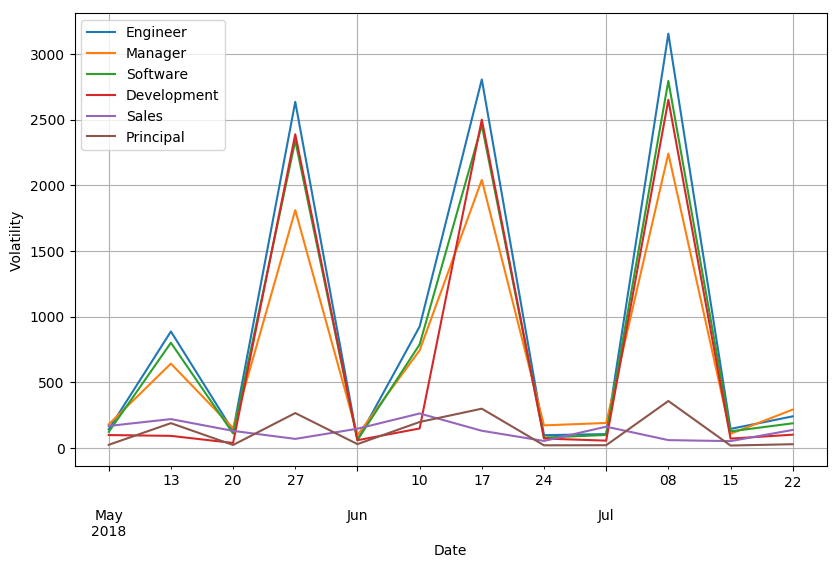

In [151]:
temp = keywords_states_dates.loc['WA'].groupby(pd.Grouper(freq='w')).std()

fig, ax = plt.subplots(figsize=(6*golden, 6), dpi=100)
temp[state_common['WA']].plot(ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Volatility')
ax.grid()

Even the volatility is volatile for WA, we also see multiple keywords act identically, engineer, manager, software, development, and somewhat principle, while sales is unaffected.

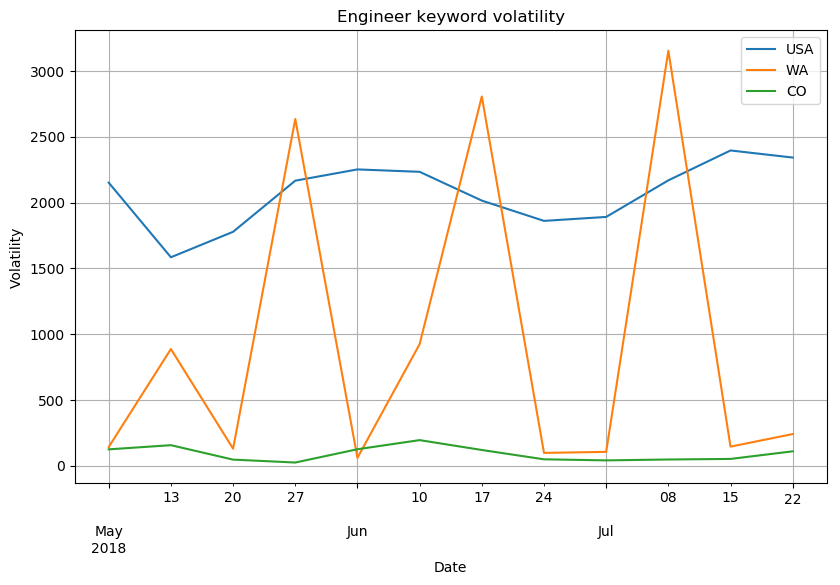

In [156]:
temp_usa = keywords_states_dates.reset_index('region').groupby(pd.Grouper(freq='W')).std()
temp_wa = keywords_states_dates.loc['WA'].groupby(pd.Grouper(freq='w')).std()
temp_co = keywords_states_dates.loc['CO'].groupby(pd.Grouper(freq='w')).std()

fig, ax = plt.subplots(figsize=(6*golden, 6), dpi=100)
temp_usa['Engineer'].plot(ax=ax, label='USA')
temp_wa['Engineer'].plot(ax=ax, label='WA')
temp_co['Engineer'].plot(ax=ax, label='CO')
ax.set_xlabel('Date')
ax.set_ylabel('Volatility')
ax.set_title('Engineer keyword volatility')
ax.grid()
ax.legend()
# ax.set_yscale('log')

What's kind of amazing to me is that the volatility of the keyword "Engineer" in can be of the same order as that of the whole US. As a comparison, CO has no such strong volatility in its keywords, meaning that WA is completely dominated by a few companies (Amazon, Microsoft) that provide a large number of jobs, but may switch on a whim.

Maybe The Data Incubator should start an office in Denver or Boulder, while WA may not be a good idea, since there probably won't be as diverse of a partner company pool.

## Future Work

I am not happy with using the keywords, there are simply too many correlated values, I would like to do principle component analysis to reduce the dimensionality to sectors of jobs so that we can have a more holisitc view of the jobs available.

Also, maybe I'll throw in a naive Bayes classifier so that a company may determine where they should expand to next.